# Visualização do Dataset original e criação do subdataset


## Etapas:

- Import das bibliotecas utilizadas para processamento, visualização e manipulação dos dados.

- Carregamento do dataset original (BraTS 2020 e BraTS 2024) e sorteio de um paciente exemplo para exploração inicial.

- Plot dos slices de todas as sequências do paciente exemplo (por um slider), mostrando a distribuição das imagens originais.

- Criação de uma tabela indicando o shape das imagens dos datasets originais.

- Criação de uma tabela mostrando a quantidade de imagens (slices) totais e com tumor por sequência, e o total consolidado de cada dataset.

- Seleção das imagens (slices) de cada sequência por paciente, filtrando apenas slices com tumor e escolhendo representações de diferentes tamanhos por meio de quantis da área do tumor. Definiu-se 4 slices no BraTS2024 e CrossDataset, e 8 slices no BraTS2020 para compensar o menor número de pacientes e no cross dataset selecionamos 4 slices de ambos.

- Conversão das imagens selecionadas para .npy e criação dos subdatasets, salvos em pastas distintas para treino, validação e teste, incluindo normalização com padding centralizado para padronizar todas as imagens em 240x240.

- Plot do mesmo paciente exemplo no novo subdataset, mostrando as slices organizadas por sequência.

- Criação de tabelas de contagem de imagens por split (train/val/test) e totais da base consolidada.

- Verificação de consistência para garantir que nenhum paciente ou imagem apareça em mais de um split.


## Imports

In [1]:
import os, glob, random, csv, math
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import pandas as pd
import hashlib
from collections import defaultdict

## Inicio do carregamento e estudo da base Brats 2020

In [2]:
# ===== BraTS 2020 LOAD =====
base_path_20 = r"C:\Users\dados\Downloads\archive\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"

patient_dirs_20 = [
    os.path.join(base_path_20, d)
    for d in os.listdir(base_path_20)
    if os.path.isdir(os.path.join(base_path_20, d)) and d.startswith("BraTS20_Training_")
]
assert len(patient_dirs_20) > 0, "Nenhuma pasta BraTS20_Training_* encontrada."

patient_folder_20 = random.choice(patient_dirs_20)
print("Paciente (2020) escolhido:", os.path.basename(patient_folder_20))

def find_modal_paths_20(patient_folder):
    patt = lambda suf: glob.glob(os.path.join(patient_folder, f"*_{suf}.nii"))
    paths = {
        "t1":    (patt("t1")    or [None])[0],
        "t1ce":  (patt("t1ce")  or [None])[0],
        "t2":    (patt("t2")    or [None])[0],
        "flair": (patt("flair") or [None])[0],
        "seg":   (patt("seg")   or [None])[0],
    }
    miss = [k for k,v in paths.items() if v is None]
    if miss:
        raise FileNotFoundError(f"Arquivos ausentes em {patient_folder}: {miss}")
    return paths

paths20 = find_modal_paths_20(patient_folder_20)

# Carrega volumes (2020)
t1_20    = nib.load(paths20["t1"]).get_fdata()
t1c_20   = nib.load(paths20["t1ce"]).get_fdata()
t2_20    = nib.load(paths20["t2"]).get_fdata()
flair_20 = nib.load(paths20["flair"]).get_fdata()
seg_20   = nib.load(paths20["seg"]).get_fdata()

mask_bin_20 = (seg_20 > 0).astype(np.uint8)
Z20 = t1_20.shape[2]

Paciente (2020) escolhido: BraTS20_Training_249


In [3]:
# ===== BraTS 2020 plot =====
def viewer_20(z):
    # Cria a figura
    plt.figure(figsize=(20, 8))

    # ---------- LINHA DE CIMA (imagens + máscara original) ----------

    # (1) T1
    plt.subplot(2, 5, 1)
    plt.imshow(t1_20[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T1")
    plt.axis("off")

    # (2) T1c
    plt.subplot(2, 5, 2)
    plt.imshow(t1c_20[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T1c")
    plt.axis("off")

    # (3) T2w
    plt.subplot(2, 5, 3)
    plt.imshow(t2_20[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T2w")
    plt.axis("off")

    # (4) FLAIR
    plt.subplot(2, 5, 4)
    plt.imshow(flair_20[:, :, z].T, cmap="gray", origin="lower")
    plt.title("FLAIR")
    plt.axis("off")

    # (5) Máscara ORIGINAL (multi-classes)
    plt.subplot(2, 5, 5)
    plt.imshow(seg_20[:, :, z].T, cmap="nipy_spectral", origin="lower")
    plt.title("Máscara (orig)")
    plt.axis("off")

    # ---------- LINHA DE BAIXO (overlays + máscara binária) ----------

    # Prepara a máscara binária da slice (H, W)
    m = (mask_bin_20[:, :, z].T > 0).astype(np.uint8)

    # (6) T1 + máscara
    plt.subplot(2, 5, 6)
    plt.imshow(t1_20[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T1 + Másc")
    plt.axis("off")

    # (7) T1c + máscara
    plt.subplot(2, 5, 7)
    plt.imshow(t1c_20[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T1c + Másc")
    plt.axis("off")

    # (8) T2w + máscara
    plt.subplot(2, 5, 8)
    plt.imshow(t2_20[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T2w + Másc")
    plt.axis("off")

    # (9) FLAIR + máscara
    plt.subplot(2, 5, 9)
    plt.imshow(flair_20[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("FLAIR + Másc")
    plt.axis("off")

    # (10) Máscara BINÁRIA
    plt.subplot(2, 5, 10)
    plt.imshow(m, cmap="gray", origin="lower")
    plt.title("Máscara (bin)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

interact(viewer_20, z=(0, Z20-1))


interactive(children=(IntSlider(value=77, description='z', max=154), Output()), _dom_classes=('widget-interact…

<function __main__.viewer_20(z)>

In [4]:
# -------- BraTS 2020 SHAPE --------
assert all(n in globals() for n in ["t1_20","t1c_20","t2_20","flair_20","seg_20"])

rows_2020 = [
    {"dataset":"BraTS2020", "modalidade":"t1",    "H": t1_20.shape[0],   "W": t1_20.shape[1],   "Z": t1_20.shape[2]},
    {"dataset":"BraTS2020", "modalidade":"t1ce",  "H": t1c_20.shape[0],  "W": t1c_20.shape[1],  "Z": t1c_20.shape[2]},
    {"dataset":"BraTS2020", "modalidade":"t2",    "H": t2_20.shape[0],   "W": t2_20.shape[1],   "Z": t2_20.shape[2]},
    {"dataset":"BraTS2020", "modalidade":"flair", "H": flair_20.shape[0],"W": flair_20.shape[1],"Z": flair_20.shape[2]},
    {"dataset":"BraTS2020", "modalidade":"seg",   "H": seg_20.shape[0],  "W": seg_20.shape[1],  "Z": seg_20.shape[2]},
]
df_2020 = pd.DataFrame(rows_2020).sort_values("modalidade").reset_index(drop=True)
df_2020

,dataset,modalidade,H,W,Z
0,BraTS2020,flair,240,240,155
1,BraTS2020,seg,240,240,155
2,BraTS2020,t1,240,240,155
3,BraTS2020,t1ce,240,240,155
4,BraTS2020,t2,240,240,155


In [5]:
assert 'base_path_20' in globals(), "Defina base_path_20 antes desta célula."

# ---------- Config (2020) ----------
_modalidades_20 = ["t1", "t1ce", "t2", "flair", "seg"]

# ---------- Helpers (2020) ----------
def _list_patient_dirs_20(base, prefix="BraTS20_Training_"):
    return [
        os.path.join(base, d)
        for d in os.listdir(base)
        if os.path.isdir(os.path.join(base, d)) and d.startswith(prefix)
    ]

def _find_modal_paths_20(patient_folder):
    hits = {m: None for m in _modalidades_20}
    for root, _, files in os.walk(patient_folder):
        for f in files:
            fl = f.lower()
            if not (fl.endswith(".nii") or fl.endswith(".nii.gz")):
                continue
            p = os.path.join(root, f)
            if "_t1ce" in fl:
                hits["t1ce"] = hits["t1ce"] or p
            elif "_t1" in fl and "t1ce" not in fl:
                hits["t1"] = hits["t1"] or p
            elif "_t2" in fl and "flair" not in fl:
                hits["t2"] = hits["t2"] or p
            elif "_flair" in fl:
                hits["flair"] = hits["flair"] or p
            elif "_seg" in fl or "-seg" in fl or fl.startswith("seg") or "label" in fl or "mask" in fl:
                hits["seg"] = hits["seg"] or p
    return hits

def _z_from_header(path):
    if path is None:
        return np.nan
    return nib.load(path).shape[2]

# ---------- Varredura (2020) ----------
patient_dirs_20 = _list_patient_dirs_20(base_path_20)
assert len(patient_dirs_20) > 0, "Nenhuma pasta BraTS20_Training_* encontrada."

# Acumuladores por sequência
slices_total_by_seq_20 = {m: 0 for m in _modalidades_20}
tumor_slices_by_seq_20 = {m: 0 for m in _modalidades_20}

n_patients_20 = 0

for pf in patient_dirs_20:
    paths = _find_modal_paths_20(pf)
    # paciente conta se tiver ao menos 1 modalidade
    if not any(paths[m] is not None for m in _modalidades_20):
        continue
    n_patients_20 += 1

    # Carrega seg uma única vez (se existir) e vetoriza tumor por fatia
    seg_path = paths["seg"]
    seg_vec = None
    z_seg = 0
    if seg_path is not None:
        seg_vol = nib.load(seg_path).get_fdata()
        z_seg = seg_vol.shape[2]
        seg_vec = np.array([(seg_vol[:, :, z] > 0).any() for z in range(z_seg)], dtype=bool)

    # Para cada sequência, soma Z e tumor slices (limitado por min(Z_seq, Z_seg))
    for m in _modalidades_20:
        p = paths[m]
        if p is None:
            continue
        z_seq = _z_from_header(p)
        if not np.isnan(z_seq):
            slices_total_by_seq_20[m] += int(z_seq)
            if (m != "seg") and (seg_vec is not None):
                # conta quantas fatias do seg têm tumor dentro do intervalo disponível na sequência
                z_use = min(int(z_seq), int(z_seg))
                tumor_slices_by_seq_20[m] += int(seg_vec[:z_use].sum())
            elif m == "seg" and seg_vec is not None:
                tumor_slices_by_seq_20[m] += int(seg_vec.sum())

# ---------- DataFrame (2020) ----------
rows_20 = []
for m in _modalidades_20:
    rows_20.append({
        "dataset": "BraTS2020",
        "sequencia": m,
        "slices_total_seq": slices_total_by_seq_20[m],
        "slices_com_tumor_seq": tumor_slices_by_seq_20[m],
    })

df_2020_summary = pd.DataFrame(rows_20)

df_2020_total = pd.DataFrame([{
    "dataset": "BraTS2020",
    "sequencia": "TODAS",
    "slices_totais_dataset": int(df_2020_summary["slices_total_seq"].sum()),
    "slices_totais_com_tumor": int(df_2020_summary["slices_com_tumor_seq"].sum()),
    "pacientes": n_patients_20
}])

df_2020_summary

,dataset,sequencia,slices_total_seq,slices_com_tumor_seq
0,BraTS2020,t1,54250,23165
1,BraTS2020,t1ce,54250,23165
2,BraTS2020,t2,54250,23165
3,BraTS2020,flair,54250,23165
4,BraTS2020,seg,54250,23165


In [6]:
df_2020_total

,dataset,sequencia,slices_totais_dataset,slices_totais_com_tumor,pacientes
0,BraTS2020,TODAS,271250,115825,350


## Inicio do carregamento e estudo da base Brats 2024

In [7]:
# ===== BraTS 2024 LOAD =====
base_path_24 = r"C:\Users\dados\Downloads\BraTS2024-BraTS-GLI-TrainingData\training_data1_v2"

patient_dirs_24 = [
    os.path.join(base_path_24, d)
    for d in os.listdir(base_path_24)
    if os.path.isdir(os.path.join(base_path_24, d)) and d.startswith("BraTS-GLI-")
]
assert len(patient_dirs_24) > 0, "Nenhuma pasta BraTS-GLI-* encontrada."

patient_folder_24 = random.choice(patient_dirs_24)
print("Paciente (2024) escolhido:", os.path.basename(patient_folder_24))

def find_modal_paths_24(patient_folder):
    def patt(suf):
        patterns = [
            os.path.join(patient_folder, f"*_{suf}.nii"),
            os.path.join(patient_folder, f"*_{suf}.nii.gz"),
            os.path.join(patient_folder, f"*-{suf}.nii"),
            os.path.join(patient_folder, f"*-{suf}.nii.gz"),
            os.path.join(patient_folder, f"*{suf}.nii"),
            os.path.join(patient_folder, f"*{suf}.nii.gz"),
        ]
        hits = []
        for p in patterns:
            hits.extend(glob.glob(p))
        return hits
    paths = {
        "t1n": (patt("t1n") or patt("t1native") or [None])[0],
        "t1c": (patt("t1c") or patt("t1ce") or patt("t1gd") or [None])[0],
        "t2w": (patt("t2w") or patt("t2") or [None])[0],
        "t2f": (patt("t2f") or patt("flair") or [None])[0],  # FLAIR equivalente
        "seg": (patt("seg") or patt("label") or patt("mask") or [None])[0],
    }
    miss = [k for k,v in paths.items() if v is None]
    if miss:
        raise FileNotFoundError(f"Arquivos ausentes em {patient_folder}: {miss}")
    return paths

paths24 = find_modal_paths_24(patient_folder_24)

# Carrega volumes (2024)
t1n_24 = nib.load(paths24["t1n"]).get_fdata()
t1c_24 = nib.load(paths24["t1c"]).get_fdata()
t2w_24 = nib.load(paths24["t2w"]).get_fdata()
t2f_24 = nib.load(paths24["t2f"]).get_fdata()   # FLAIR no 2024
seg_24  = nib.load(paths24["seg"]).get_fdata()

mask_bin_24 = (seg_24 > 0).astype(np.uint8)
Z24 = t1n_24.shape[2]

Paciente (2024) escolhido: BraTS-GLI-02833-101


In [8]:
# ===== BraTS 2024 plot =====
def viewer_24(z):
    # Cria a figura
    plt.figure(figsize=(20, 8))

    # ---------- LINHA DE CIMA (imagens brutas + máscara original) ----------

    # (1) T1n
    plt.subplot(2, 5, 1)
    plt.imshow(t1n_24[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T1n")
    plt.axis("off")

    # (2) T1c
    plt.subplot(2, 5, 2)
    plt.imshow(t1c_24[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T1c")
    plt.axis("off")

    # (3) T2w
    plt.subplot(2, 5, 3)
    plt.imshow(t2w_24[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T2w")
    plt.axis("off")

    # (4) T2f / FLAIR
    plt.subplot(2, 5, 4)
    plt.imshow(t2f_24[:, :, z].T, cmap="gray", origin="lower")
    plt.title("T2f / FLAIR")
    plt.axis("off")

    # (5) Máscara ORIGINAL (pode ter múltiplas classes)
    plt.subplot(2, 5, 5)
    plt.imshow(seg_24[:, :, z].T, cmap="nipy_spectral", origin="lower")
    plt.title("Máscara (orig)")
    plt.axis("off")

    # ---------- LINHA DE BAIXO (overlays + máscara binária) ----------

    # Prepara a máscara binária da slice (H, W)
    m = (mask_bin_24[:, :, z].T > 0).astype(np.uint8)

    # (6) T1n + máscara
    plt.subplot(2, 5, 6)
    plt.imshow(t1n_24[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T1n + Másc")
    plt.axis("off")

    # (7) T1c + máscara
    plt.subplot(2, 5, 7)
    plt.imshow(t1c_24[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T1c + Másc")
    plt.axis("off")

    # (8) T2w + máscara
    plt.subplot(2, 5, 8)
    plt.imshow(t2w_24[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T2w + Másc")
    plt.axis("off")

    # (9) T2f / FLAIR + máscara
    plt.subplot(2, 5, 9)
    plt.imshow(t2f_24[:, :, z].T, cmap="gray", origin="lower")
    plt.imshow(m, cmap="Reds", alpha=0.35, origin="lower")
    plt.title("T2f + Másc")
    plt.axis("off")

    # (10) Máscara BINÁRIA
    plt.subplot(2, 5, 10)
    plt.imshow(m, cmap="gray", origin="lower")
    plt.title("Máscara (bin)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

interact(viewer_24, z=(0, Z24-1))

interactive(children=(IntSlider(value=90, description='z', max=181), Output()), _dom_classes=('widget-interact…

<function __main__.viewer_24(z)>

In [9]:
# -------- BraTS 2024 SHAPE --------
assert all(n in globals() for n in ["t1n_24","t1c_24","t2w_24","t2f_24","seg_24"])

rows_2024 = [
    {"dataset":"BraTS2024", "modalidade":"t1n", "H": t1n_24.shape[0], "W": t1n_24.shape[1], "Z": t1n_24.shape[2]},
    {"dataset":"BraTS2024", "modalidade":"t1c", "H": t1c_24.shape[0], "W": t1c_24.shape[1], "Z": t1c_24.shape[2]},
    {"dataset":"BraTS2024", "modalidade":"t2w", "H": t2w_24.shape[0], "W": t2w_24.shape[1], "Z": t2w_24.shape[2]},
    {"dataset":"BraTS2024", "modalidade":"t2f", "H": t2f_24.shape[0], "W": t2f_24.shape[1], "Z": t2f_24.shape[2]},
    {"dataset":"BraTS2024", "modalidade":"seg", "H": seg_24.shape[0],  "W": seg_24.shape[1],  "Z": seg_24.shape[2]},
]
df_2024 = pd.DataFrame(rows_2024).sort_values("modalidade").reset_index(drop=True)
df_2024

,dataset,modalidade,H,W,Z
0,BraTS2024,seg,182,218,182
1,BraTS2024,t1c,182,218,182
2,BraTS2024,t1n,182,218,182
3,BraTS2024,t2f,182,218,182
4,BraTS2024,t2w,182,218,182


In [10]:
assert 'base_path_24' in globals(), "Defina base_path_24 antes desta célula."

# ---------- Config (2024) ----------
_modalidades_24 = ["t1n", "t1c", "t2w", "t2f", "seg"]

# ---------- Helpers (2024) ----------
def _list_patient_dirs_24(base, prefix="BraTS-GLI-"):
    return [
        os.path.join(base, d)
        for d in os.listdir(base)
        if os.path.isdir(os.path.join(base, d)) and d.startswith(prefix)
    ]

def _find_modal_paths_24(patient_folder):
    hits = {m: None for m in _modalidades_24}
    for root, _, files in os.walk(patient_folder):
        for f in files:
            fl = f.lower()
            if not (fl.endswith(".nii") or fl.endswith(".nii.gz")):
                continue
            p = os.path.join(root, f)
            if ("t1n" in fl) or ("t1native" in fl):
                hits["t1n"] = hits["t1n"] or p
            elif ("t1c" in fl) or ("t1ce" in fl) or ("t1gd" in fl):
                hits["t1c"] = hits["t1c"] or p
            elif ("t2w" in fl) or (("t2" in fl) and ("flair" not in fl) and ("t2f" not in fl)):
                hits["t2w"] = hits["t2w"] or p
            elif ("t2f" in fl) or ("flair" in fl):
                hits["t2f"] = hits["t2f"] or p
            elif ("_seg" in fl) or (fl.startswith("seg")) or ("-seg" in fl) or ("label" in fl) or ("mask" in fl):
                hits["seg"] = hits["seg"] or p
    return hits

def _z_from_header(path):
    if path is None:
        return np.nan
    return nib.load(path).shape[2]

# ---------- Varredura (2024) ----------
patient_dirs_24 = _list_patient_dirs_24(base_path_24)
assert len(patient_dirs_24) > 0, "Nenhuma pasta BraTS-GLI-* encontrada."

slices_total_by_seq_24 = {m: 0 for m in _modalidades_24}
tumor_slices_by_seq_24 = {m: 0 for m in _modalidades_24}

n_patients_24 = 0

for pf in patient_dirs_24:
    paths = _find_modal_paths_24(pf)
    if not any(paths[m] is not None for m in _modalidades_24):
        continue
    n_patients_24 += 1

    seg_path = paths["seg"]
    seg_vec = None
    z_seg = 0
    if seg_path is not None:
        seg_vol = nib.load(seg_path).get_fdata()
        z_seg = seg_vol.shape[2]
        seg_vec = np.array([(seg_vol[:, :, z] > 0).any() for z in range(z_seg)], dtype=bool)

    for m in _modalidades_24:
        p = paths[m]
        if p is None:
            continue
        z_seq = _z_from_header(p)
        if not np.isnan(z_seq):
            slices_total_by_seq_24[m] += int(z_seq)
            if (m != "seg") and (seg_vec is not None):
                z_use = min(int(z_seq), int(z_seg))
                tumor_slices_by_seq_24[m] += int(seg_vec[:z_use].sum())
            elif m == "seg" and seg_vec is not None:
                tumor_slices_by_seq_24[m] += int(seg_vec.sum())

# ---------- DataFrame (2024) ----------
rows_24 = []
for m in _modalidades_24:
    rows_24.append({
        "dataset": "BraTS2024",
        "sequencia": m,
        "slices_total_seq": slices_total_by_seq_24[m],
        "slices_com_tumor_seq": tumor_slices_by_seq_24[m],
    })

df_2024_summary = pd.DataFrame(rows_24)

df_2024_total = pd.DataFrame([{
    "dataset": "BraTS2024",
    "sequencia": "TODAS",
    "slices_totais_dataset": int(df_2024_summary["slices_total_seq"].sum()),
    "slices_totais_com_tumor": int(df_2024_summary["slices_com_tumor_seq"].sum()),
    "pacientes": n_patients_24
}])

df_2024_summary

,dataset,sequencia,slices_total_seq,slices_com_tumor_seq
0,BraTS2024,t1n,245700,90807
1,BraTS2024,t1c,245700,90807
2,BraTS2024,t2w,245700,90807
3,BraTS2024,t2f,245700,90807
4,BraTS2024,seg,245700,90807


In [11]:
df_2024_total

,dataset,sequencia,slices_totais_dataset,slices_totais_com_tumor,pacientes
0,BraTS2024,TODAS,1228500,454035,1350


## Inicio da separação e visualização do subdataset Baseline 2020

In [ ]:
# Separador 2020

BASELINE_2020 = r"C:\Users\dados\Documents\mini_datasets\baseline2020"
DTYPE_SAVE_IMG = np.float32
DTYPE_SAVE_MASK = np.uint8
SEQ_KEYS_2020 = ["t1","t1ce","t2","flair","seg"]

os.makedirs(BASELINE_2020, exist_ok=True)

# ---------- FUNÇÕES AUX ----------
def find_modal_paths_20(patient_folder):
    patt = lambda suf: glob.glob(os.path.join(patient_folder, f"*_{suf}.nii"))
    paths = {
        "t1":    (patt("t1")    or [None])[0],
        "t1ce":  (patt("t1ce")  or [None])[0],
        "t2":    (patt("t2")    or [None])[0],
        "flair": (patt("flair") or [None])[0],
        "seg":   (patt("seg")   or [None])[0],
    }
    miss = [k for k,v in paths.items() if v is None]
    if miss: raise FileNotFoundError(f"Ausentes em {patient_folder}: {miss}")
    return paths

def select_eight_by_area_from_mask(seg_bin):
    areas = seg_bin.sum(axis=(0,1))
    z_idx = np.where(areas > 0)[0]
    if len(z_idx) == 0:
        return [], areas
    order = z_idx[np.argsort(areas[z_idx])]

    # quantis concentrados na região central
    QUANTIS = [0.10, 0.25, 0.40, 0.50, 0.60, 0.75, 0.85, 0.95]
    if len(order) >= 8:
        picks = [order[int(round((len(order)-1)*q))] for q in QUANTIS]
        uniq  = list(dict.fromkeys(int(i) for i in picks))
        if len(uniq) < 8:
            remaining = [int(z) for z in order if z not in uniq][::-1]
            for z in remaining:
                uniq.append(z)
                if len(uniq) == 8: break
        sel = sorted(uniq)
    else:
        base = order.tolist()
        i = 0
        while len(base) < 8:
            base.append(order[i % len(order)])
            i += 1
        sel = sorted(int(z) for z in base[:8])
    return sel, areas

def pad_to_240(slice2d):
    """Pad centralizado para garantir shape (240,240)."""
    H, W = slice2d.shape
    out = np.zeros((240, 240), dtype=slice2d.dtype)
    y0 = (240 - H) // 2
    x0 = (240 - W) // 2
    out[y0:y0+H, x0:x0+W] = slice2d
    return out

# ---------- PACIENTES ----------
patient_dirs_20 = [
    os.path.join(base_path_20, d)
    for d in os.listdir(base_path_20)
    if os.path.isdir(os.path.join(base_path_20, d)) and d.startswith("BraTS20_Training_")
]
assert len(patient_dirs_20) == 350, f"Esperados 350 pacientes, encontrado {len(patient_dirs_20)}"

# divisão: 245 train, 52 val, 53 test
patients_sorted = sorted(patient_dirs_20)
splits = {
    "train": patients_sorted[:245],
    "val":   patients_sorted[245:297],
    "test":  patients_sorted[297:350],
}

# ---------- LOOP PRINCIPAL ----------
for split_name, split_patients in splits.items():
    rows = []
    split_dir = os.path.join(BASELINE_2020, split_name)
    os.makedirs(split_dir, exist_ok=True)

    for pdir in split_patients:
        pid = os.path.basename(pdir)
        try:
            paths = find_modal_paths_20(pdir)

            # carrega volumes
            t1    = nib.load(paths["t1"]).get_fdata(dtype=np.float32)
            t1ce  = nib.load(paths["t1ce"]).get_fdata(dtype=np.float32)
            t2    = nib.load(paths["t2"]).get_fdata(dtype=np.float32)
            flair = nib.load(paths["flair"]).get_fdata(dtype=np.float32)
            seg   = nib.load(paths["seg"]).get_fdata()
            seg_b = (seg > 0).astype(DTYPE_SAVE_MASK)

            sel_z, areas = select_eight_by_area_from_mask(seg_b)
            if len(sel_z) == 0:
                continue

            # cria pasta do paciente e subpastas de sequências
            out_patient = os.path.join(split_dir, pid)
            for seq in SEQ_KEYS_2020:
                os.makedirs(os.path.join(out_patient, seq), exist_ok=True)

            H, W, Z = flair.shape
            for k, z in enumerate(sel_z):
                files = {}
                for key, vol in (("flair",flair),("t1",t1),("t1ce",t1ce),("t2",t2)):
                    arr = vol[:, :, z].astype(DTYPE_SAVE_IMG, copy=False)
                    if arr.shape != (240, 240):
                        arr = pad_to_240(arr)
                    fname = f"{key}_z{z:03d}_{k:02d}.npy"
                    fpath = os.path.join(out_patient, key, fname)
                    np.save(fpath, arr)
                    files[key] = os.path.relpath(fpath, BASELINE_2020)

                # máscara
                m = seg_b[:, :, z]
                if m.shape != (240, 240):
                    m = pad_to_240(m)
                fname_m = f"seg_z{z:03d}_{k:02d}.npy"
                fpath_m = os.path.join(out_patient, "seg", fname_m)
                np.save(fpath_m, m)
                files["seg"] = os.path.relpath(fpath_m, BASELINE_2020)

                rows.append({
                    "ano": 2020,
                    "paciente": pid,
                    "z": int(z),
                    "idx_local": k,
                    "area_tumor_px": int(areas[z]),
                    "H": int(H), "W": int(W),
                    **{fpath: files[fpath] for fpath in SEQ_KEYS_2020}
                })

        except Exception as e:
            print(f"[ERRO {split_name}] {pid}: {e}")

    # salvar metadata de cada split
    meta = pd.DataFrame(rows, columns=["ano","paciente","z","idx_local","area_tumor_px","H","W",*SEQ_KEYS_2020])
    csv_path = os.path.join(BASELINE_2020, f"metadata_2020_{split_name}.csv")
    meta.to_csv(csv_path, index=False, quoting=csv.QUOTE_MINIMAL)
    print(f"[{split_name.upper()}] {len(split_patients)} pacientes -> {len(meta)} slices salvos | metadata: {csv_path}")

,split,pacientes,t1,t1ce,t2,flair,seg,total_slices,% slices
0,train,245,1960,1960,1960,1960,1960,9800,70.00
1,val,52,416,416,416,416,416,2080,14.86
2,test,53,424,424,424,424,424,2120,15.14


,pacientes,t1,t1ce,t2,flair,seg,total_slices
0,350,2800,2800,2800,2800,2800,14000


Paciente BraTS20_Training_249 encontrado no split 'val'.


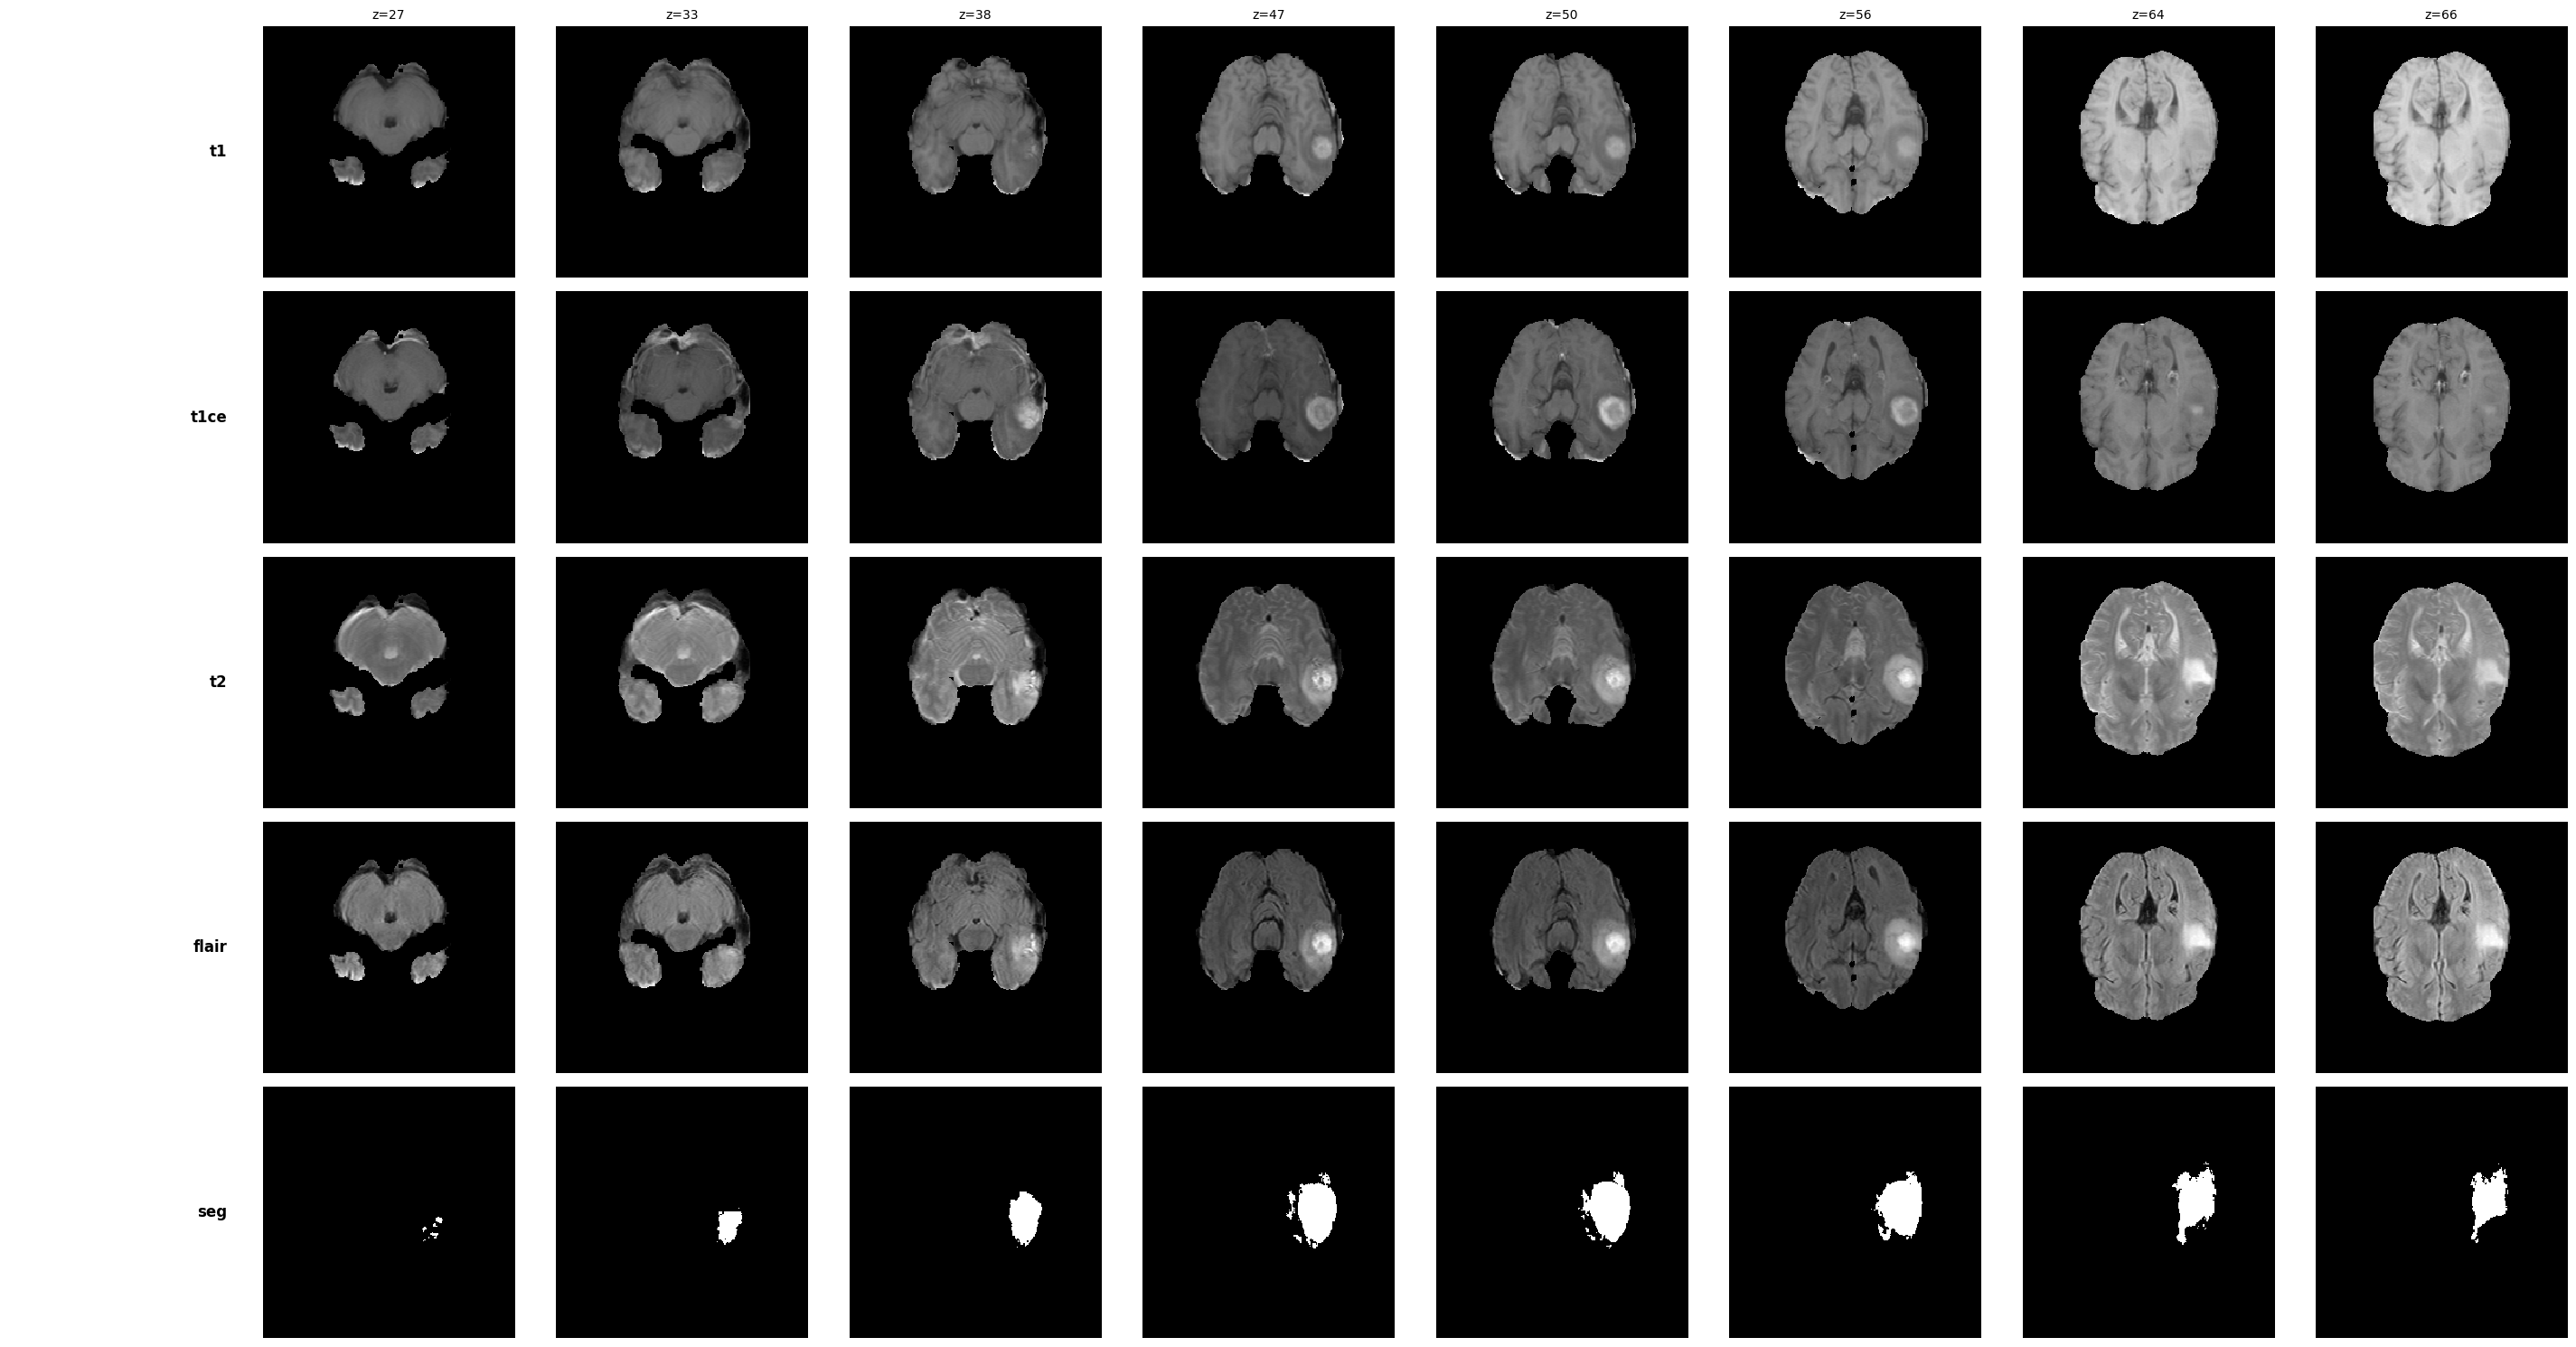

In [12]:
BASELINE_2020   = r"C:\Users\dados\Documents\mini_datasets\baseline2020"
SEQ_2020        = ["t1","t1ce","t2","flair","seg"]

# 1) Consolidar estatísticas de todos os splits (com % dinâmica)
rows_summary = []
total_pacientes_all = 0
total_slices_all = 0
counts_total = {seq: 0 for seq in SEQ_2020}

for split in ["train", "val", "test"]:
    meta = pd.read_csv(os.path.join(BASELINE_2020, f"metadata_2020_{split}.csv"))
    pacientes_split = meta["paciente"].nunique()
    total_pacientes_all += pacientes_split
    total_slices_all += len(meta)

    # contagem por sequência no split
    counts_split = {seq: int(meta[seq].notna().sum()) for seq in SEQ_2020}
    # acumula no total
    for seq in SEQ_2020:
        counts_total[seq] += counts_split[seq]

    # total de “células” (slice × seq) nesse split
    total_cells_split = sum(counts_split.values())

    rows_summary.append({
        "split": split,
        "pacientes": pacientes_split,
        **counts_split,
        "total_slices": total_cells_split,  # mantém o nome da sua coluna
        # % será preenchido depois com denominador dinâmico
    })

df_summary = pd.DataFrame(rows_summary)

# Denominador dinâmico: soma dos totais de “células” em todos os splits
grand_total_cells = df_summary["total_slices"].sum()
df_summary["% slices"] = (100 * df_summary["total_slices"] / grand_total_cells).round(2)

display(df_summary)

# 2) DataFrame com totais da base
# total_slices agora é a soma real das células (não usa número fixo)
df_total = pd.DataFrame([{
    "pacientes": total_pacientes_all,
    **counts_total,
    "total_slices": sum(counts_total.values())
}])
display(df_total)

# === Seleciona paciente do DataLoader ou fallback ===
if "patient_folder_20" in globals():
    pid20 = os.path.basename(patient_folder_20)
else:
    # fallback: primeiro paciente do train
    meta_tmp = pd.read_csv(os.path.join(BASELINE_2020, "metadata_2020_train.csv"))
    pid20 = meta_tmp["paciente"].iloc[0]

# === Descobre em qual split o paciente está ===
split_found = None
rows20 = None
for split in ["train", "val", "test"]:
    meta_path = os.path.join(BASELINE_2020, f"metadata_2020_{split}.csv")
    meta_tmp = pd.read_csv(meta_path)
    if pid20 in meta_tmp["paciente"].values:
        split_found = split
        rows20 = meta_tmp.loc[meta_tmp["paciente"] == pid20].sort_values(["idx_local","z"]).reset_index(drop=True)
        break

assert rows20 is not None, f"Paciente {pid20} não encontrado em nenhum split!"
print(f"Paciente {pid20} encontrado no split '{split_found}'.")

# === Função de carregamento ===
def load_npy_2020(rel_path):
    return np.load(os.path.join(BASELINE_2020, rel_path))

# === Carregar slices ===
seq2slices_20 = {k: [] for k in SEQ_2020}
sel_z_20 = []
for _, r in rows20.iterrows():
    for seq in SEQ_2020:
        seq2slices_20[seq].append(load_npy_2020(r[seq]))
    sel_z_20.append(int(r["z"]))

# garante no máximo 8 colunas
for k in SEQ_2020:
    seq2slices_20[k] = seq2slices_20[k][:8]
sel_z_20 = sel_z_20[:8]


# garante no máximo 8 colunas
for k in SEQ_2020:
    seq2slices_20[k] = seq2slices_20[k][:8]
sel_z_20 = sel_z_20[:8]

# 5) Plot — 1 coluna de rótulo + 8 colunas de imagens
ncols = len(sel_z_20)
fig, axes = plt.subplots(len(SEQ_2020), ncols+1,
                         figsize=(3.2*(ncols+1), 3.0*len(SEQ_2020)),
                         gridspec_kw={"width_ratios":[0.8]+[1]*ncols})

for r, seq in enumerate(SEQ_2020):
    # Coluna de rótulo
    ax_label = axes[r,0]
    ax_label.axis("off")
    ax_label.text(0.95, 0.5, seq, ha="right", va="center", fontsize=12, weight="bold")

    # Slices
    for c, z in enumerate(sel_z_20, start=1):
        ax = axes[r,c]
        img = np.rot90(seq2slices_20[seq][c-1])  # rotação CCW 90°
        ax.imshow(img, cmap="gray", interpolation="nearest")
        ax.axis("off")
        if r == 0:
            ax.set_title(f"z={z}", fontsize=10)

plt.tight_layout()
plt.show()

## Inicio da separação e visualização do subdataset Baseline 2024

In [ ]:
# Separador 2024

BASELINE_2024 = r"C:\Users\dados\Documents\mini_datasets\baseline2024"
DTYPE_SAVE_IMG = np.float32
DTYPE_SAVE_MASK = np.uint8
SEQ_KEYS_2024 = ["t1n","t1c","t2w","t2f","seg"]

os.makedirs(BASELINE_2024, exist_ok=True)

# ---------- FUNÇÕES AUX ----------
def find_modal_paths_24(patient_folder):
    def patt(suf):
        patterns = [
            os.path.join(patient_folder, f"*_{suf}.nii"),
            os.path.join(patient_folder, f"*_{suf}.nii.gz"),
            os.path.join(patient_folder, f"*-{suf}.nii"),
            os.path.join(patient_folder, f"*-{suf}.nii.gz"),
            os.path.join(patient_folder, f"*{suf}.nii"),
            os.path.join(patient_folder, f"*{suf}.nii.gz"),
        ]
        hits = []
        for p in patterns: hits.extend(glob.glob(p))
        return hits
    paths = {
        "t1n": (patt("t1n") or patt("t1native") or [None])[0],
        "t1c": (patt("t1c") or patt("t1ce") or patt("t1gd") or [None])[0],
        "t2w": (patt("t2w") or patt("t2") or [None])[0],
        "t2f": (patt("t2f") or patt("flair") or [None])[0],
        "seg": (patt("seg") or patt("label") or patt("mask") or [None])[0],
    }
    miss = [k for k,v in paths.items() if v is None]
    if miss: raise FileNotFoundError(f"Ausentes em {patient_folder}: {miss}")
    return paths

def select_four_by_area_from_mask(seg_bin):
    areas = seg_bin.sum(axis=(0,1))
    z_idx = np.where(areas > 0)[0]
    if len(z_idx) == 0:
        return [], areas
    order = z_idx[np.argsort(areas[z_idx])]

    # quantis (4 cortes)
    QUANTIS = [0.2, 0.4, 0.6, 0.8]
    if len(order) >= 4:
        picks = [order[int(round((len(order)-1)*q))] for q in QUANTIS]
        uniq  = list(dict.fromkeys(int(i) for i in picks))
        if len(uniq) < 4:
            remaining = [int(z) for z in order if z not in uniq][::-1]
            for z in remaining:
                uniq.append(z)
                if len(uniq) == 4: break
        sel = sorted(uniq)
    else:
        base = order.tolist()
        i = 0
        while len(base) < 4:
            base.append(order[i % len(order)])
            i += 1
        sel = sorted(int(z) for z in base[:4])
    return sel, areas

def pad_to_240(slice2d):
    """Pad centralizado para garantir shape (240,240)."""
    H, W = slice2d.shape
    out = np.zeros((240, 240), dtype=slice2d.dtype)
    y0 = (240 - H) // 2
    x0 = (240 - W) // 2
    out[y0:y0+H, x0:x0+W] = slice2d
    return out

# ---------- PACIENTES ----------
patient_dirs_24 = [
    os.path.join(base_path_24, d)
    for d in os.listdir(base_path_24)
    if os.path.isdir(os.path.join(base_path_24, d)) and d.startswith("BraTS-GLI-")
]
assert len(patient_dirs_24) == 1350, f"Esperados 1350 pacientes, encontrado {len(patient_dirs_24)}"

# divisão: 945 train, 202 val, 203 test
patients_sorted = sorted(patient_dirs_24)
splits = {
    "train": patients_sorted[:945],
    "val":   patients_sorted[945:1147],
    "test":  patients_sorted[1147:1350],
}

# ---------- LOOP PRINCIPAL ----------
for split_name, split_patients in splits.items():
    rows = []
    split_dir = os.path.join(BASELINE_2024, split_name)
    os.makedirs(split_dir, exist_ok=True)

    for pdir in split_patients:
        pid = os.path.basename(pdir)
        try:
            paths = find_modal_paths_24(pdir)

            # carrega volumes
            t1n = nib.load(paths["t1n"]).get_fdata(dtype=np.float32)
            t1c = nib.load(paths["t1c"]).get_fdata(dtype=np.float32)
            t2w = nib.load(paths["t2w"]).get_fdata(dtype=np.float32)
            t2f = nib.load(paths["t2f"]).get_fdata(dtype=np.float32)
            seg = nib.load(paths["seg"]).get_fdata()
            seg_b = (seg > 0).astype(DTYPE_SAVE_MASK)

            sel_z, areas = select_four_by_area_from_mask(seg_b)
            if len(sel_z) == 0:
                continue

            # cria pasta do paciente e subpastas de sequências
            out_patient = os.path.join(split_dir, pid)
            for seq in SEQ_KEYS_2024:
                os.makedirs(os.path.join(out_patient, seq), exist_ok=True)

            H, W, Z = t2f.shape
            for k, z in enumerate(sel_z):
                files = {}
                for key, vol in (("t1n",t1n),("t1c",t1c),("t2w",t2w),("t2f",t2f)):
                    arr = vol[:, :, z].astype(DTYPE_SAVE_IMG, copy=False)
                    if arr.shape != (240, 240):
                        arr = pad_to_240(arr)
                    fname = f"{key}_z{z:03d}_{k:02d}.npy"
                    fpath = os.path.join(out_patient, key, fname)
                    np.save(fpath, arr)
                    files[key] = os.path.relpath(fpath, BASELINE_2024)

                # máscara
                m = seg_b[:, :, z]
                if m.shape != (240, 240):
                    m = pad_to_240(m)
                fname_m = f"seg_z{z:03d}_{k:02d}.npy"
                fpath_m = os.path.join(out_patient, "seg", fname_m)
                np.save(fpath_m, m)
                files["seg"] = os.path.relpath(fpath_m, BASELINE_2024)

                rows.append({
                    "ano": 2024,
                    "paciente": pid,
                    "z": int(z),
                    "idx_local": k,
                    "area_tumor_px": int(areas[z]),
                    "H": int(H), "W": int(W),
                    **{fpath: files[fpath] for fpath in SEQ_KEYS_2024}
                })

        except Exception as e:
            print(f"[ERRO {split_name}] {pid}: {e}")

    # salvar metadata de cada split
    meta = pd.DataFrame(rows, columns=["ano","paciente","z","idx_local","area_tumor_px","H","W",*SEQ_KEYS_2024])
    csv_path = os.path.join(BASELINE_2024, f"metadata_2024_{split_name}.csv")
    meta.to_csv(csv_path, index=False, quoting=csv.QUOTE_MINIMAL)
    print(f"[{split_name.upper()}] {len(split_patients)} pacientes -> {len(meta)} slices salvos | metadata: {csv_path}")

,split,pacientes,t1n,t1c,t2w,t2f,seg,total_slices,% slices
0,train,945,3780,3780,3780,3780,3780,18900,70.00
1,val,202,808,808,808,808,808,4040,14.96
2,test,203,812,812,812,812,812,4060,15.04


,pacientes,t1n,t1c,t2w,t2f,seg,total_slices
0,1350,5400,5400,5400,5400,5400,27000


Paciente BraTS-GLI-02833-101 encontrado no split 'val'.


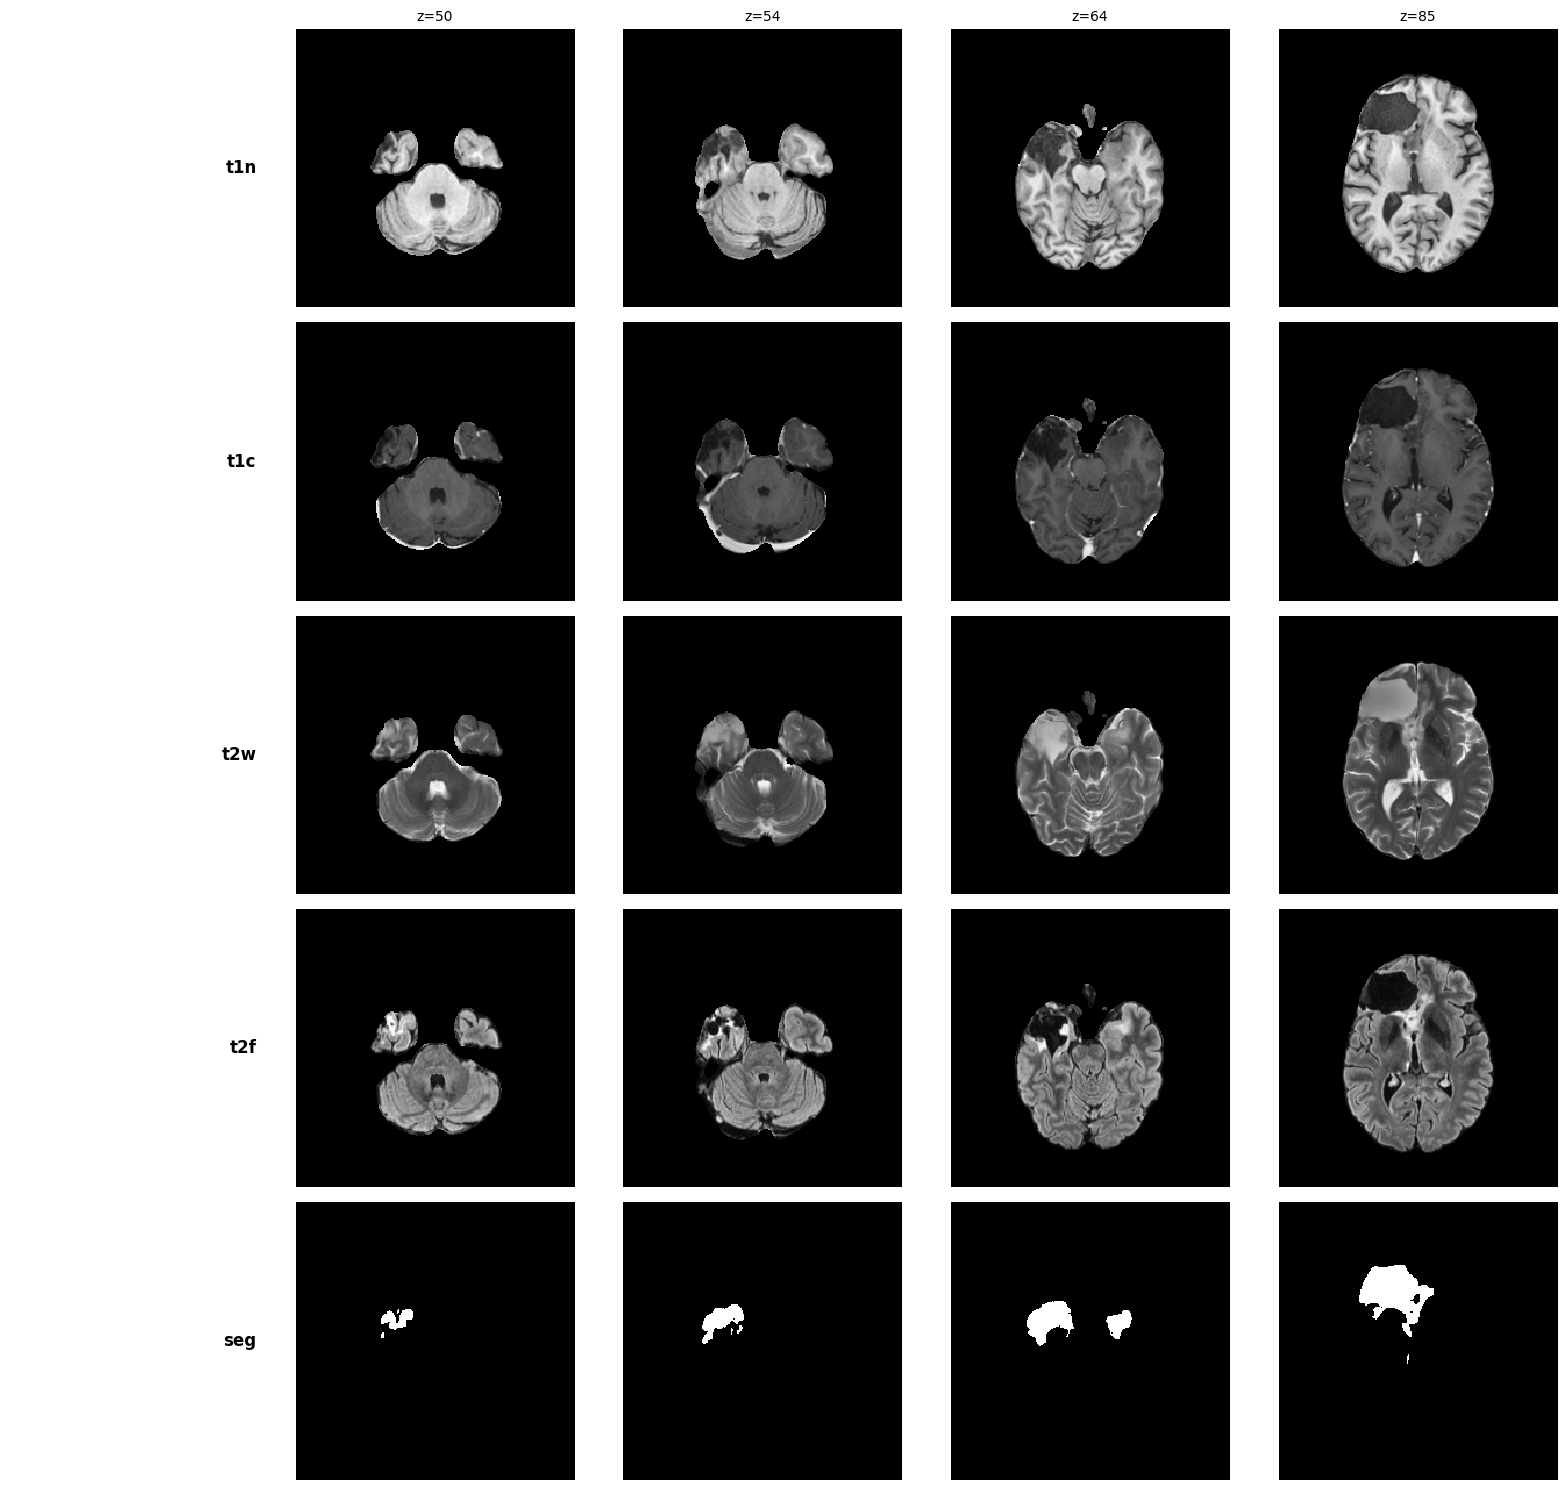

In [13]:
BASELINE_2024   = r"C:\Users\dados\Documents\mini_datasets\baseline2024"
SEQ_2024        = ["t1n","t1c","t2w","t2f","seg"]

# 1) Consolidar estatísticas de todos os splits
rows_summary = []
total_pacientes_all = 0
total_slices_all = 0
counts_total = {seq: 0 for seq in SEQ_2024}

for split in ["train","val","test"]:
    meta = pd.read_csv(os.path.join(BASELINE_2024, f"metadata_2024_{split}.csv"))
    pacientes_split = meta["paciente"].nunique()
    total_pacientes_all += pacientes_split
    total_slices_all += len(meta)
    for seq in SEQ_2024:
        counts_total[seq] += int(meta[seq].notna().sum())

    counts_split = {seq: int(meta[seq].notna().sum()) for seq in SEQ_2024}
    total_slices = sum(counts_split[s] for s in SEQ_2024)
    rows_summary.append({
        "split": split,
        "pacientes": pacientes_split,
        **counts_split,
        "total_slices": total_slices
        # "% slices" será calculado dinamicamente abaixo
    })

df_summary = pd.DataFrame(rows_summary)

# Denominador dinâmico: soma dos totais de “células” (slice×seq) em todos os splits
grand_total_cells = df_summary["total_slices"].sum()
df_summary["% slices"] = (100 * df_summary["total_slices"] / grand_total_cells).round(2)

display(df_summary)

# 2) DataFrame com totais da base (dinâmico)
df_total = pd.DataFrame([{
    "pacientes": total_pacientes_all,
    **counts_total,
    "total_slices": sum(counts_total.values())
}])
display(df_total)

if "patient_folder_24" in globals():
    pid24 = os.path.basename(patient_folder_24)
else:
    meta_tmp = pd.read_csv(os.path.join(BASELINE_2024, "metadata_2024_train.csv"))
    pid24 = meta_tmp["paciente"].iloc[0]

split_found = None
rows24 = None
for split in ["train", "val", "test"]:
    meta_path = os.path.join(BASELINE_2024, f"metadata_2024_{split}.csv")
    meta_tmp = pd.read_csv(meta_path)
    if pid24 in meta_tmp["paciente"].values:
        split_found = split
        rows24 = meta_tmp.loc[meta_tmp["paciente"] == pid24].sort_values(["idx_local","z"]).reset_index(drop=True)
        break

assert rows24 is not None, f"Paciente {pid24} não encontrado em nenhum split!"
print(f"Paciente {pid24} encontrado no split '{split_found}'.")

def load_npy_2024(rel_path):
    return np.load(os.path.join(BASELINE_2024, rel_path))

seq2slices_24 = {k: [] for k in SEQ_2024}
sel_z_24 = []
for _, r in rows24.iterrows():
    for seq in SEQ_2024:
        seq2slices_24[seq].append(load_npy_2024(r[seq]))
    sel_z_24.append(int(r["z"]))

for k in SEQ_2024:
    seq2slices_24[k] = seq2slices_24[k][:4]
sel_z_24 = sel_z_24[:4]


# 5) Plot — 1 coluna de rótulo + 4 colunas de imagens
ncols = len(sel_z_24)
fig, axes = plt.subplots(len(SEQ_2024), ncols+1,
                         figsize=(3.2*(ncols+1), 3.0*len(SEQ_2024)),
                         gridspec_kw={"width_ratios":[0.8]+[1]*ncols})

for r, seq in enumerate(SEQ_2024):
    # Coluna de rótulo
    ax_label = axes[r,0]
    ax_label.axis("off")
    ax_label.text(0.95, 0.5, seq, ha="right", va="center", fontsize=12, weight="bold")

    # Slices
    for c, z in enumerate(sel_z_24, start=1):
        ax = axes[r,c]
        img = np.rot90(seq2slices_24[seq][c-1])  # rotação CCW 90°
        ax.imshow(img, cmap="gray", interpolation="nearest")
        ax.axis("off")
        if r == 0:
            ax.set_title(f"z={z}", fontsize=10)

plt.tight_layout()
plt.show()

## Inicio da separação e visualização do subdataset Crossdataset

In [ ]:
# Separador crossdataset

CROSSDATASET = r"C:\Users\dados\Documents\mini_datasets\crossdataset"
DTYPE_SAVE_IMG = np.float32
DTYPE_SAVE_MASK = np.uint8

SEQ_KEYS_2024 = ["t1n","t1c","t2w","t2f","seg"]
SEQ_KEYS_2020 = ["t1","t1ce","t2","flair","seg"]

os.makedirs(CROSSDATASET, exist_ok=True)

# ---------- FUNÇÕES AUX ----------
def find_modal_paths_24(patient_folder):
    def patt(suf):
        patterns = [
            os.path.join(patient_folder, f"*_{suf}.nii"),
            os.path.join(patient_folder, f"*_{suf}.nii.gz"),
            os.path.join(patient_folder, f"*-{suf}.nii"),
            os.path.join(patient_folder, f"*-{suf}.nii.gz"),
            os.path.join(patient_folder, f"*{suf}.nii"),
            os.path.join(patient_folder, f"*{suf}.nii.gz"),
        ]
        hits = []
        for p in patterns: hits.extend(glob.glob(p))
        return hits
    return {
        "t1n": (patt("t1n") or patt("t1native") or [None])[0],
        "t1c": (patt("t1c") or patt("t1ce") or patt("t1gd") or [None])[0],
        "t2w": (patt("t2w") or patt("t2") or [None])[0],
        "t2f": (patt("t2f") or patt("flair") or [None])[0],
        "seg": (patt("seg") or patt("label") or patt("mask") or [None])[0],
    }

def find_modal_paths_20(patient_folder):
    patt = lambda suf: glob.glob(os.path.join(patient_folder, f"*_{suf}.nii"))
    return {
        "t1":    (patt("t1")    or [None])[0],
        "t1ce":  (patt("t1ce")  or [None])[0],
        "t2":    (patt("t2")    or [None])[0],
        "flair": (patt("flair") or [None])[0],
        "seg":   (patt("seg")   or [None])[0],
    }

def select_four_by_area_from_mask(seg_bin):
    areas = seg_bin.sum(axis=(0,1))
    z_idx = np.where(areas > 0)[0]
    if len(z_idx) == 0:
        return [], areas
    order = z_idx[np.argsort(areas[z_idx])]
    QUANTIS = [0.2, 0.4, 0.6, 0.8]
    if len(order) >= 4:
        picks = [order[int(round((len(order)-1)*q))] for q in QUANTIS]
        uniq  = list(dict.fromkeys(int(i) for i in picks))
        if len(uniq) < 4:
            remaining = [int(z) for z in order if z not in uniq][::-1]
            for z in remaining:
                uniq.append(z)
                if len(uniq) == 4: break
        sel = sorted(uniq)
    else:
        base = order.tolist()
        while len(base) < 4:
            base.extend(order[:4-len(base)])
        sel = sorted(int(z) for z in base[:4])
    return sel, areas

def pad_to_240(slice2d):
    H, W = slice2d.shape
    out = np.zeros((240, 240), dtype=slice2d.dtype)
    y0 = (240 - H) // 2
    x0 = (240 - W) // 2
    out[y0:y0+H, x0:x0+W] = slice2d
    return out

# ---------- PACIENTES ----------
patient_dirs_24 = [
    os.path.join(base_path_24, d)
    for d in os.listdir(base_path_24)
    if os.path.isdir(os.path.join(base_path_24, d)) and d.startswith("BraTS-GLI-")
]
patient_dirs_20 = [
    os.path.join(base_path_20, d)
    for d in os.listdir(base_path_20)
    if os.path.isdir(os.path.join(base_path_20, d)) and d.startswith("BraTS20_Training_")
]

assert len(patient_dirs_24) == 1350, f"Esperados 1350 pacientes 2024, encontrado {len(patient_dirs_24)}"
assert len(patient_dirs_20) == 350, f"Esperados 350 pacientes 2020, encontrado {len(patient_dirs_20)}"

# divisão: 1080 train (2024), 270 val (2024), 350 test (2020)
patients_sorted_24 = sorted(patient_dirs_24)
patients_sorted_20 = sorted(patient_dirs_20)

splits = {
    "train": ("2024", patients_sorted_24[:1080]),
    "val":   ("2024", patients_sorted_24[1080:1350]),
    "test":  ("2020", patients_sorted_20)
}

# ---------- LOOP PRINCIPAL ----------
for split_name, (year, split_patients) in splits.items():
    rows = []
    split_dir = os.path.join(CROSSDATASET, split_name)
    os.makedirs(split_dir, exist_ok=True)

    for pdir in split_patients:
        pid = os.path.basename(pdir)
        try:
            if year == "2024":
                paths = find_modal_paths_24(pdir)
                vols = {
                    "t1n": nib.load(paths["t1n"]).get_fdata(dtype=np.float32),
                    "t1c": nib.load(paths["t1c"]).get_fdata(dtype=np.float32),
                    "t2w": nib.load(paths["t2w"]).get_fdata(dtype=np.float32),
                    "t2f": nib.load(paths["t2f"]).get_fdata(dtype=np.float32),
                    "seg": nib.load(paths["seg"]).get_fdata(),
                }
                SEQ_KEYS = SEQ_KEYS_2024
            else:  # 2020
                paths = find_modal_paths_20(pdir)
                vols = {
                    "t1":    nib.load(paths["t1"]).get_fdata(dtype=np.float32),
                    "t1ce":  nib.load(paths["t1ce"]).get_fdata(dtype=np.float32),
                    "t2":    nib.load(paths["t2"]).get_fdata(dtype=np.float32),
                    "flair": nib.load(paths["flair"]).get_fdata(dtype=np.float32),
                    "seg":   nib.load(paths["seg"]).get_fdata(),
                }
                SEQ_KEYS = SEQ_KEYS_2020

            seg_b = (vols["seg"] > 0).astype(DTYPE_SAVE_MASK)
            sel_z, areas = select_four_by_area_from_mask(seg_b)
            if len(sel_z) == 0:
                continue

            # cria pasta do paciente e subpastas
            out_patient = os.path.join(split_dir, pid)
            for seq in SEQ_KEYS:
                os.makedirs(os.path.join(out_patient, seq), exist_ok=True)

            H, W, Z = list(vols.values())[0].shape
            for k, z in enumerate(sel_z):
                files = {}
                for key in SEQ_KEYS[:-1]:  # todas menos seg
                    arr = vols[key][:, :, z].astype(DTYPE_SAVE_IMG, copy=False)
                    if arr.shape != (240, 240):
                        arr = pad_to_240(arr)
                    fname = f"{key}_z{z:03d}_{k:02d}.npy"
                    fpath = os.path.join(out_patient, key, fname)
                    np.save(fpath, arr)
                    files[key] = os.path.relpath(fpath, CROSSDATASET)

                # máscara
                m = seg_b[:, :, z]
                if m.shape != (240, 240):
                    m = pad_to_240(m)
                fname_m = f"seg_z{z:03d}_{k:02d}.npy"
                fpath_m = os.path.join(out_patient, "seg", fname_m)
                np.save(fpath_m, m)
                files["seg"] = os.path.relpath(fpath_m, CROSSDATASET)

                rows.append({
                    "ano": int(year),
                    "paciente": pid,
                    "z": int(z),
                    "idx_local": k,
                    "area_tumor_px": int(areas[z]),
                    "H": int(H), "W": int(W),
                    **{fpath: files[fpath] for fpath in SEQ_KEYS}
                })

        except Exception as e:
            print(f"[ERRO {split_name}] {pid}: {e}")

    # salvar metadata
    meta = pd.DataFrame(rows, columns=["ano","paciente","z","idx_local","area_tumor_px","H","W",*SEQ_KEYS])
    csv_path = os.path.join(CROSSDATASET, f"metadata_cross_{split_name}.csv")
    meta.to_csv(csv_path, index=False, quoting=csv.QUOTE_MINIMAL)
    print(f"[{split_name.upper()}] {year} -> {len(split_patients)} pacientes -> {len(meta)} slices salvos | metadata: {csv_path}")

In [14]:
# Neste mostramos apenas o shape pois as imagens são as mesmas do 2020 e 2024
CROSSDATASET = r"C:\Users\dados\Documents\mini_datasets\crossdataset"

# Mapeamento de equivalência
SEQ_EQUIV = {
    "t1n": "t1",
    "t1": "t1",
    "t1c": "t1ce",
    "t1ce": "t1ce",
    "t2w": "t2",
    "t2": "t2",
    "t2f": "flair",
    "flair": "flair",
    "seg": "seg"
}

SEQ_UNIFICADAS = ["t1", "t1ce", "t2", "flair", "seg"]

# 1) Consolidar estatísticas
rows_summary = []
total_pacientes_all = 0
total_slices_all = 0
counts_total = {seq: 0 for seq in SEQ_UNIFICADAS}

for split in ["train","val","test"]:
    meta = pd.read_csv(os.path.join(CROSSDATASET, f"metadata_cross_{split}.csv"))
    pacientes_split = meta["paciente"].nunique()
    total_pacientes_all += pacientes_split
    total_slices_all += len(meta)

    # Detectar se é 2020 ou 2024
    ano = meta["ano"].iloc[0]
    if ano == 2024:
        SEQ_KEYS = ["t1n","t1c","t2w","t2f","seg"]
    else:
        SEQ_KEYS = ["t1","t1ce","t2","flair","seg"]

    # Contagem de slices mapeando equivalência
    counts_split = {seq: 0 for seq in SEQ_UNIFICADAS}
    for seq in SEQ_KEYS:
        equiv = SEQ_EQUIV[seq]
        counts_split[equiv] += int(meta[seq].notna().sum())

    # Somar no total global
    for seq in SEQ_UNIFICADAS:
        counts_total[seq] += counts_split[seq]

    total_slices = sum(counts_split.values())
    rows_summary.append({
        "split": split,
        "ano": ano,
        "pacientes": pacientes_split,
        **counts_split,
        "total_slices": total_slices
        # "% slices" será calculado dinamicamente abaixo (separado por ano)
    })

df_summary = pd.DataFrame(rows_summary)

# Denominador dinâmico POR ANO: cada linha divide pelo total do próprio ano
totais_por_ano = df_summary.groupby("ano")["total_slices"].transform("sum")
df_summary["% slices"] = (100 * df_summary["total_slices"] / totais_por_ano).round(2)

display(df_summary)

# 2) DataFrame com totais da base crossdataset (já unificado)
df_total = pd.DataFrame([{
    "pacientes": total_pacientes_all,
    **counts_total,
    "total_slices": sum(counts_total.values())
}])
display(df_total)

,split,ano,pacientes,t1,t1ce,t2,flair,seg,total_slices,% slices
0,train,2024,1080,4320,4320,4320,4320,4320,21600,80.0
1,val,2024,270,1080,1080,1080,1080,1080,5400,20.0
2,test,2020,350,1400,1400,1400,1400,1400,7000,100.0


,pacientes,t1,t1ce,t2,flair,seg,total_slices
0,1700,6800,6800,6800,6800,6800,34000


## Verificação de duplicatas nas imagens e duplicatas de pacientes

In [15]:
# mostra se existem apcientes duplicados nos splits

def collect_overlaps(dataset_path, prefix):
    meta_train = pd.read_csv(os.path.join(dataset_path, f"metadata_{prefix}_train.csv"))
    meta_val   = pd.read_csv(os.path.join(dataset_path, f"metadata_{prefix}_val.csv"))
    meta_test  = pd.read_csv(os.path.join(dataset_path, f"metadata_{prefix}_test.csv"))

    p_train = set(meta_train["paciente"].unique())
    p_val   = set(meta_val["paciente"].unique())
    p_test  = set(meta_test["paciente"].unique())

    return {
        "dataset": prefix,
        "train ∩ val": len(p_train & p_val),
        "train ∩ test": len(p_train & p_test),
        "val ∩ test": len(p_val & p_test)
    }

# Caminhos das bases
BASELINE_2020 = r"C:\Users\dados\Documents\mini_datasets\baseline2020"
BASELINE_2024 = r"C:\Users\dados\Documents\mini_datasets\baseline2024"
CROSSDATASET = r"C:\Users\dados\Documents\mini_datasets\crossdataset"

# Coletar overlaps dos três
overlaps = []
overlaps.append(collect_overlaps(BASELINE_2020, "2020"))
overlaps.append(collect_overlaps(BASELINE_2024, "2024"))
overlaps.append(collect_overlaps(CROSSDATASET, "cross"))

# Criar DataFrame único
df_overlaps = pd.DataFrame(overlaps)
display(df_overlaps)

,dataset,train ∩ val,train ∩ test,val ∩ test
0,2020,0,0,0
1,2024,0,0,0
2,cross,0,0,0
